In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from sklearn import preprocessing
import tslearn.utils
from tslearn.clustering import TimeSeriesKMeans
import geopandas as gpd
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual, SelectMultiple, RadioButtons, interact, Layout
import matplotlib.colors as colors
import plotly
import plotly.express as px

In [2]:
# World countries names from geopandas
world_df = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
countries_world = set(world_df['name'])

# Global income inequality

## Are resources produced by a country equally distributed among citizens?

In order to dig inside this question, we decide to study how income is distributed in the different countries.

Indeed, in previous analyses, we discovered how some countries are more responsible for the production in term of crops and livestock. Production causes emission of CO2, which is one of the main causes of Climate Change. 

Of course, we cannot target the production as *bad* a priori: indeed, production is important for the economy and overall wealth of a country. However, it could be important to analyze how income and wealth is distributed within each country among its inhabitants, i.e. inspect how economic resources earned by productive activities are split.

A quite common phenomenon that can be detected in many countries all over the world is the so called **Matthew Effect**, which can be summarized in the sentence *the rich gets richer and the poor gets poorer*.

In FAO dataset, there were no information about this aspect: thus we need to retrieve some data from the World Inequality Database ([here](https://wid.world/data/)).

The WID aims to provide open and convenient access to the most extensive available database on the historical evolution of the world distribution of income and wealth, both within countries and between countries.
We have already cleaned this dataset during data cleaning phase: below, you can find an example on how it look like.

In [3]:
# Read dataset
inequality = pd.read_pickle("pickle/inequality_ref.pkl")
inequality.loc['China'][['Poor50','Top1']].tail()

,Poor50,Top1
Year,,
2013,0.1450,0.1381
2014,0.1486,0.1366
2015,0.1483,0.1392
2016,0.0000,0.0000
2017,0.0000,0.0000


The DataFrame showed above it's divided by country and reports which percentage of the total amount of income is earned by the *Bottom 50% percent* (the poorests) and by the *Top 1%* (the richests) of the population of a given country.

We first define an utility function, which helps us dealing with NaN values.

In [4]:
def set_nan(x):
    if x == 0:
        return np.nan
    else:
        return x

In [5]:
inequality = inequality.applymap(set_nan)

In order to give a visual example of the **Matthew Effect** we plot 6 countries, from different continents; these plots could help to understand the phenomenon we are talking about. We try to show 6 different situations: we will dig into similarities and differences among countries later.

In [6]:
# Selected countries
countries = ['France','United States of America','Botswana','China','Russia','India']

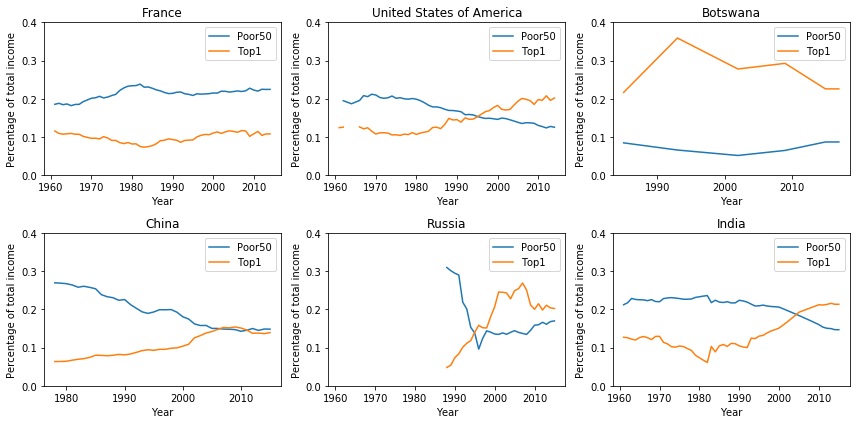

In [7]:
f,a = plt.subplots(2,3 ,figsize=(12,6))
a = a.ravel()
for idx,ax in enumerate(a):
    df = inequality.drop('Top10',axis=1)
    df = df.reset_index().set_index(['Area'])
    df = df.loc[countries[idx],].set_index('Year')
    ax.plot(df)
    ax.set_title(countries[idx])
    ax.set_xlabel('Year')
    ax.set_ylabel('Percentage of total income')
    ax.set_ylim(0,0.4)
    ax.legend(['Poor50','Top1'])
plt.tight_layout()

These plots well explain the effect we were describing above, which is evolving faster and faster in recent years. While in European countries (that have France as a representative country) managed to contain the phenomenon, developing countries like China or India are having great issues in controlling it. Interestingly enough, United States have a situation nearer to developing countries than to big economies like European ones: the gap between the rich and the poor part of the population is becoming more and more wide in recent years. Finally, Russian situation clearly describes what happened after the end of URRS.

## Before we start... Feature engineering

Before further analyzing the whole set of countries, we have to fix some issue which prevent us from effectively exploit `tslearn` package for time series analysis.

The first problem is that a consistent fraction of countries does not have data at all about the distribution of the income of the poorest part of the popualtion, i.e. `Poor50` column: to deal with this issue, we artificially build that time series by observing that, given the distribution for the richest part (`Top1` column), the distribution of the poorest part is usually a constant fraction of the remaining percentage of wealth, and thus we can reconstruct the `Poor50` time series on the basis of the `Top1` column.

In [8]:
# Define fraction
interp = inequality.reset_index().groupby('Year').mean()
interp = interp.Poor50/(1-interp.Top1)

In [9]:
np.mean(interp), np.std(interp)

(0.2297367956350025, 0.03241036226410951)

From this data, we can infer that about 23% of income not earned by the richest 1% of the population is earned by the poorest 50% (with a reasonable standard deviation): we will use this ratio to articifically construct missing time series.

In [10]:
# Utility function
alpha = np.mean(interp)
def completePoor50(ts):
    ts['Poor50'] = (1-ts['Top1'])*alpha
    return ts

In [11]:
# Select Poor50 and Top1
inequality = inequality[['Poor50','Top1']]

In [12]:
inequality.tail()

Poor50      Top1
Area     Year                    
eSwatini 2013  0.095234  0.182021
         2014  0.095234  0.182021
         2015  0.095234  0.182021
         2016  0.095234  0.182021
         2017  0.095234  0.182021

## Clustering countries: which areas show similar patterns?

Our idea is to perform clustering with world countries, in order to show if, exploiting this unsupervised learning technique, we are able to define groups based on the features of the times series.

Thanks to features engineering, we managed to have, for each country, the time series from 1980 to 2017. Unfortunately, some countries are not in the original dataset, and thus data are not available.

We start with an analysis and clustering based on the whole time series. We use the **k-means** algorithm for clustering.

In [13]:
# Define variables
ts_dataset = list()
years = range(1980,2018)
countries = inequality.reset_index().Area.unique()
countries_cluster = []
counter = 0;

In [14]:
# Build time series
for c in countries:
    ts = inequality.reset_index().set_index(['Area'])
    ts = ts.loc[c,].set_index('Year')
    ts = ts.loc[years,].fillna(method='ffill').fillna(method='bfill')
    if ts.isna().values.any() == True:
        counter = counter + 1
        ts = completePoor50(ts)
        if ts.isna().values.any() == True:
            continue
    countries_cluster = countries_cluster + [c]
    ts_dataset.append(ts.values)

In [15]:
# Check for the use of artificial time series
len(countries), counter

(115, 11)

Note that the time series for `Poor50` was artificially build in 11 countries only (less that 10% of the total).

In [16]:
# Check for missing countries
set(countries).difference(countries_cluster)

set()

Therefore, no other problem appeared in data, since all time series were correctly added to the dataset (which mean that they do not contain missing values).

In [17]:
# Create time series dataset
ts_dataset = tslearn.utils.to_time_series_dataset(ts_dataset)

In [18]:
# Compute k-means clustering for different k values
mse = []
for i in range(2,7):
    kmeans = tslearn.clustering.TimeSeriesKMeans(metric='dtw',n_clusters=i,max_iter=100, random_state=1111)
    clusters = kmeans.fit_predict(ts_dataset)
    mse.append(kmeans.inertia_)

Clustering task is performed using the function provided with the `tslearn` package, `tslearn.clustering.TimeSeriesKMeans`. The distance function used to compute pairwise distances among time series is the **Dynamic Time Warping**: a general introduction and more information on pros and cons of this measure can be found [here](https://medium.com/datadriveninvestor/dynamic-time-warping-dtw-d51d1a1e4afc).

Let's first have a look at the behaviour of the mean squared error.

Text(0, 0.5, 'MSE')

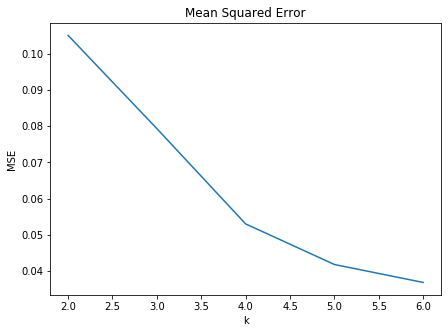

In [19]:
# Mean squared errors for different k
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(range(2,7),mse)
ax.set_title('Mean Squared Error')
ax.set_xlabel('k')
ax.set_ylabel('MSE')

For the clustering on the whole time series, we will use 4 clusters.

In [20]:
# Recompute clusters labels with k = 4
kmeans = tslearn.clustering.TimeSeriesKMeans(metric='dtw',n_clusters=4,max_iter=100, random_state=1111)
clusters = kmeans.fit_predict(ts_dataset)
clusters = pd.Series(clusters).rename('Clusters')
clusters.index = countries_cluster
clusters.name = 'Cluster'

In [21]:
# Example: have a look at cluster 1 (European countries, mainly)
clusters[clusters==1].index

Index(['Albania', 'Australia', 'Austria', 'Belgium', 'Bosnia and Herz.',
       'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Estonia',
       'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland',
       'Indonesia', 'Ireland', 'Italy', 'Japan', 'Latvia', 'Lithuania',
       'Luxembourg', 'Macedonia', 'Moldova', 'Montenegro', 'Netherlands',
       'New Zealand', 'Norway', 'Poland', 'Portugal', 'Romania', 'Serbia',
       'Slovakia', 'Slovenia', 'South Korea', 'Spain', 'Sweden', 'Switzerland',
       'Taiwan', 'United Kingdom'],
      dtype='object')

We now try to use k-means algorithm to analyze our data in three different periods in time. 

The function below helps us to build the clustering model, in a way similar to what we have done before using the complete time series from 1980 to 2017.
In particular, we split each time series into the following three time periods:
* 1980-1990
* 1991-2002
* 2003-2017

Given that data for each clustering algorithm are fewer with respect to the single time period, and optimizing the number of clusters for each time period is not consistent with our purpouse, we decide to create 3 clusters only, to avoid bad clustering phenomena (such as a cluster containing just few countries).

In [22]:
def build_clusters(years_):
    
    # Define variables
    ts_dataset = list()
    years = range(years_[0],years_[1])
    countries = inequality.reset_index().Area.unique()
    countries_cluster = []
    
    # Build time series
    for c in countries:
        ts = inequality.reset_index().set_index(['Area'])
        ts = ts.loc[c,].set_index('Year')
        ts = ts.loc[years,].fillna(method='ffill').fillna(method='bfill')
        if ts.isna().values.any() == True:
            ts = completePoor50(ts)
            if ts.isna().values.any() == True:
                continue
        countries_cluster = countries_cluster + [c]
        ts_dataset.append(ts.values)
        
    # Create time series dataset
    ts_dataset = tslearn.utils.to_time_series_dataset(ts_dataset)
    
    # Compute k-means clustering
    kmeans = tslearn.clustering.TimeSeriesKMeans(metric='dtw',n_clusters=3,max_iter=100,random_state=1111)
    clusters = kmeans.fit_predict(ts_dataset)
    clusters = pd.Series(clusters).rename('Clusters')
    clusters.index = countries_cluster
    
    # Redefine clusters fixing some countries
    chi = clusters['China']
    clusters = clusters.replace(chi, 'CH')
    fra = clusters['France']
    clusters = clusters.replace(fra, 'FR')
    bot = clusters['Botswana']
    clusters = clusters.replace(bot, 'BW')

    return clusters

In [23]:
# Apply function in different time periods
clustersT = pd.DataFrame(index=countries)
yearsT = [(1980,1990),(1990,2003),(2003,2018)]
for y in yearsT:
     clustersT[str(y[0])+'-'+str(y[1])] = build_clusters(y)

The last part of the function deals with the following problem: in order to have a nice visualization of the evolution in time of the different clusters, it is useful to have sort of continuity among the labeling of the clusters themself. 

Indeed, while some countries could be grouped together in each period, the actual cluster label (number) may be different, depending on how the algorithm arbitrarly labeled them. For example, Scandinavian countries were grouped together in all the time periods, but were labeled each time with a different cluster number (eg : 1980-1990: Cluster 2, 1991-2003: Cluster 3).

In order to solve this issue, we decide to fix the cluster label for some specific countries (which never happen to be grouped together), namely *China* (Cluster 1), *France* (Cluster 2) and *Botswana* (Cluster 3).

Let's have a quick look at the income distribution pattern for these countries.

In [24]:
# Selected countries
countries = ['China','France','Botswana']
titles = ['Cluster1 : China-like','Cluster2 : France-like','Cluster3 : Botswana-like']

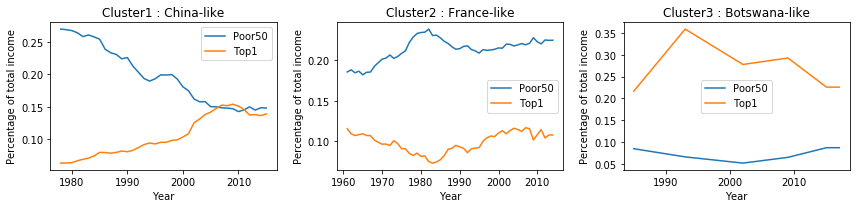

In [25]:
# Plots
f,a = plt.subplots(1,3 ,figsize=(12,3))
a = a.ravel()
for idx, ax in enumerate(a):
    df = inequality.reset_index().set_index(['Area'])
    df = df.loc[countries[idx],].set_index('Year')
    ax.plot(df)
    ax.set_title(titles[idx])
    ax.set_xlabel('Year')
    ax.set_ylabel('Percentage of total income')
    ax.legend(['Poor50','Top1'])
plt.tight_layout()

In [26]:
# Function to relabel clusters
def substitute(x):
    if x=='CH':
        return 1
    if x=='FR':
        return 2
    if x=='BW':
        return 3

In [27]:
# Apply function to dataset
clustersT = clustersT.applymap(substitute)

In [28]:
clustersT.head()

,1980-1990,1990-2003,2003-2018
Albania,NaN,2.0,2
Algeria,3.0,NaN,2
Angola,NaN,NaN,1
Argentina,NaN,NaN,1
Australia,2.0,2.0,2


As mentioned before we have no data for some countries: we group all of them together, assigning cluster number 0.

In [29]:
# Fill missing information
clustersT = clustersT.fillna(0)
missing = countries_world.difference(clustersT.index)
zero = [0, 0, 0]
for i in missing:
    clustersT.loc[i] = zero

Now, we simply need to reformat and clean the new dataset.

In [30]:
# Reformat and clean
clustersT = pd.DataFrame(clustersT).stack().reset_index()
clustersT = clustersT.rename(columns={'level_0':'Country','level_1':'Years',0:'Cluster'})
clustersT = clustersT.set_index('Country')

In [31]:
# Build Choroplet map DataFrame
merged = world_df.set_index('name').join(clustersT)
merged = merged.dropna(subset=['Cluster'])
merged = merged.reset_index().rename(columns={'index':'Country'})

In [32]:
# Fix map problems
merged.loc[merged['Country'] =='France', 'iso_a3'] = 'FRA'
merged.loc[merged['Country'] =='Norway', 'iso_a3'] = 'NOR'

In [ ]:
# Show map
fig = px.choropleth(merged, locations="iso_a3", color="Cluster", hover_name="Country", animation_frame="Years",
                    color_continuous_scale='Temps', color_continuous_midpoint=1, range_color=[0,3])
fig.show()

### Comments

The choropleth map helps us with the visualization of the clusters. We can easily see how the European countries were clustered together, such as most of the developing countries like Brazil or India. 

We were interested on the behaviour of those countries which are involved the most in the production of CO2. From the map and from the plots below, we can see how they suffer of the **Matthew Effect**.

This leads to consider these countries as top level not only in terms of agriculture and livestock prodcution, but also in terms of income inequality. 

In order to dig more carefully into this problem, we should consider how all the earnings of different branches (Industry, Agriculture, Turism, Services, etc.), are related to income inequality: however, we would need additional data (which are hardly to obtain) and much more work to provide insights about this issue.